This notebook is a slightly modified version of:
https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/

#### Config

In [1]:
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0

# possible  `data_type` values: "random_circles", "MNIST"
data_type = "MNIST"


## Imports and Setup 

#### Preamble

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

import keras.layers as kl
import keras

Using TensorFlow backend.


In [4]:
import pandas as pd

from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

#### Notebook Configuration 

In [5]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [6]:
'TensorFlow version: ' + K.tf.__version__

'TensorFlow version: 1.11.0'

## Data

#### Random Circles

In [7]:
import cv2
import numpy.random as rnd

In [8]:
rnd.randint(0, 100)

1

In [9]:
def generate_image(img_size = (100, 150)):
    img = np.zeros(img_size + (3,))
    
    x = rnd.randint(0, img_size[1])
    y = rnd.randint(0, img_size[0])

    cv2.circle(img,(x,y), 10, (0,0,255), -1)
    
    return img/255

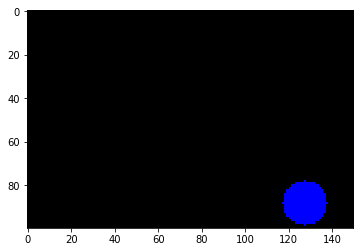

In [10]:
img = generate_image()
plt.imshow(img)

In [11]:
if data_type == "random_circles":
    x_train = np.array([generate_image() for i in range(60000)])
    print(x_train.shape)
    x_test = np.array([generate_image() for i in range(10000)])
    print(x_test.shape)

#### MNIST

In [12]:
from keras.datasets import mnist

In [13]:
if data_type == "MNIST":
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1) / 255.
    x_test = np.expand_dims(x_test, axis=-1) / 255.
    
    print(x_train.shape)
    print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Model specification

##### Constant definitions

In [14]:
input_shape = img_rows, img_cols, img_chns = x_train.shape[1:]
input_shape

(28, 28, 1)

In [15]:
original_dim = np.prod(input_shape)

### Encoder

#### Inference network

In [16]:
x = kl.Input(shape=input_shape, name='x')
x_flat = kl.Flatten()(x)
h = kl.Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x_flat)
z_mu = kl.Dense(latent_dim, name='mu')(h)
z_log_var = kl.Dense(latent_dim, name='log_var')(h)
z_sigma = kl.Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)

In [17]:
infer = keras.Model(inputs=x, outputs=[z_mu, z_sigma], name = "infer")

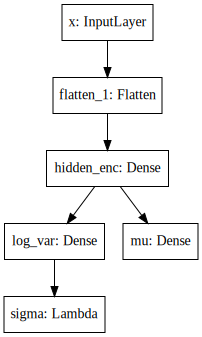

In [18]:
SVG(model_to_dot(infer, show_shapes=False)
    .create(prog='dot', format='svg'))

#### Reparameterization with Merge Layers

In [19]:
z_mu = kl.Input(shape=(latent_dim,), name='mu')
z_sigma = kl.Input(shape=(latent_dim,), name='sigma')
eps = kl.Input(shape=(latent_dim,), name='eps')
z_eps = kl.Multiply(name='z_eps')([z_sigma, eps])
z = kl.Add(name='z')([z_mu, z_eps])

In [20]:
reparam = keras.Model(inputs=[eps, z_mu, z_sigma], outputs=z, name = "reparam")

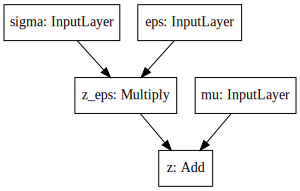

In [21]:
SVG(model_to_dot(reparam, show_shapes=False)
    .create(prog='dot', format='svg'))

#### Auxiliary layer adding Kullback-Leibler part of the loss

In [22]:
class KLDivergenceLayer(kl.Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, sigma = inputs
        log_var = K.log(sigma**2)

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs
    
kl_loss_layer = KLDivergenceLayer(name = "kl_loss_layer")

#### Composition -- stochastic encoder

In [23]:
infer.input

<tf.Tensor 'x:0' shape=(?, 28, 28, 1) dtype=float32>

In [24]:
infer.output

[<tf.Tensor 'mu/BiasAdd:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'sigma/Exp:0' shape=(?, 2) dtype=float32>]

In [25]:
reparam.input

[<tf.Tensor 'eps:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'mu_1:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'sigma_1:0' shape=(?, 2) dtype=float32>]

In [26]:
x = kl.Input(shape=input_shape, name='x')
#eps = kl.Input(shape=(latent_dim,), name='eps')
eps = kl.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)), name ='eps')


In [27]:
mu, sigma = infer(x)

In [28]:
mu, sigma = kl_loss_layer([mu, sigma])

In [29]:
z = reparam(inputs = [eps, mu, sigma])

In [30]:
encoder = keras.Model(
    inputs = [x, eps],
    outputs = z,
    name = "encoder"
)

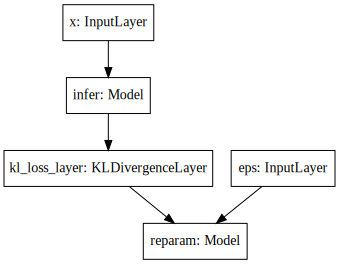

In [31]:
SVG(model_to_dot(encoder, show_shapes=False)
    .create(prog='dot', format='svg'))

### Decoder

In [32]:
decoder = keras.Sequential([
    kl.InputLayer(input_shape=(latent_dim,), name='z'),
    kl.Dense(intermediate_dim, input_shape=(latent_dim,),
          activation='relu', name='hidden_dec'),
    kl.Dense(original_dim, activation='sigmoid', name='x_pred'),
    kl.Reshape(input_shape)
], name='decoder')

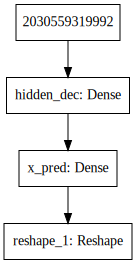

In [33]:
SVG(model_to_dot(decoder, show_shapes=False)
    .create(prog='dot', format='svg'))

### Specifying the VAE

In [34]:
x_pred = decoder(z)

In [35]:
vae = keras.Model(inputs=[x, eps], outputs=x_pred)

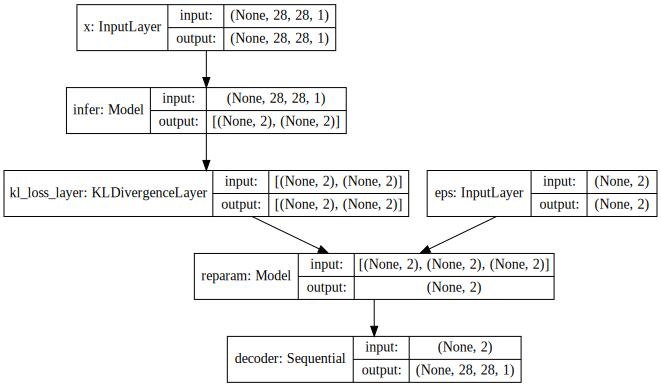

In [36]:
SVG(model_to_dot(vae, show_shapes=True)
    .create(prog='dot', format='svg'))

In [37]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the image pixels. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=(-1, -2, -3))
    

In [38]:
vae.compile(optimizer='rmsprop', loss=nll)

In [39]:
vae.predict(x_train).shape

(60000, 28, 28, 1)

## Model fitting

In [40]:
hist = vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 39us/step - loss: 190.7299 - val_loss: 172.4754
Epoch 2/50
60000/60000 [==============================] - 2s 36us/step - loss: 170.3201 - val_loss: 168.0511
Epoch 3/50
60000/60000 [==============================] - 2s 33us/step - loss: 166.8213 - val_loss: 165.6554
Epoch 4/50
60000/60000 [==============================] - 2s 33us/step - loss: 164.7019 - val_loss: 164.2700
Epoch 5/50
60000/60000 [==============================] - 2s 33us/step - loss: 163.1754 - val_loss: 162.7378
Epoch 6/50
60000/60000 [==============================] - 2s 34us/step - loss: 161.9343 - val_loss: 161.8897
Epoch 7/50
60000/60000 [==============================] - 2s 33us/step - loss: 160.8557 - val_loss: 160.5523
Epoch 8/50
60000/60000 [==============================] - 2s 34us/step - loss: 159.8801 - val_loss: 159.8359
Epoch 9/50
60000/60000 [==============================] - 2s 34us/step - loss:

## Model Evaluation

In [41]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

### NELBO

(147.83287886123657, 187.35211360422772)

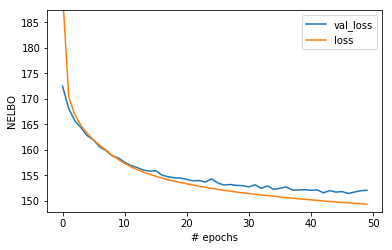

In [42]:
fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())

#plt.savefig('../../images/vae/nelbo.svg', format='svg')
#plt.show()

### Observed space manifold

In [43]:
# display a 2D manifold of the images
n = 15  # figure with 15x15 images
quantile_min = 0.01
quantile_max = 0.99

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n))
z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

In [44]:
x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape((n, n)+ input_shape)

In [45]:
def stack_image_grid(img_grid):
    return np.block(
        list(map(list, np.transpose(img_grid, (0, 1, 4, 2, 3))))
    ).transpose(1, 2, 0)

In [46]:
stacked_x_pred_grid = stack_image_grid(x_pred_grid)
# if img_chns == 1:
#     stacked_x_pred_grid = 

Text(0, 0.5, '$z_2$')

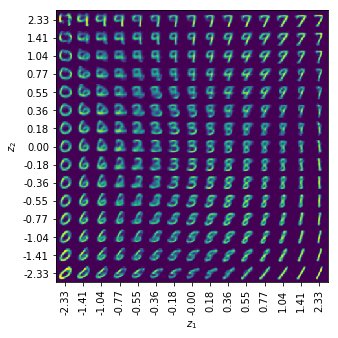

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(np.squeeze(stack_image_grid(x_pred_grid)))

ax.set_xticks(np.arange(0, n*img_rows, img_rows) + .5 * img_rows)
ax.set_xticklabels(map('{:.2f}'.format, z1), rotation=90)

ax.set_yticks(np.arange(0, n*img_cols, img_cols) + .5 * img_cols)
ax.set_yticklabels(map('{:.2f}'.format, z2))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

# plt.savefig('../../images/vae/result_manifold.png')
# plt.show()

In [48]:
norm.ppf(quantile_min), norm.ppf(quantile_max)

(-2.3263478740408408, 2.3263478740408408)

In [49]:
import ipywidgets as ipw

In [50]:
def plot_decoded(q1, q2):
    z1 = norm.ppf(q1)
    z2 = norm.ppf(q2)
    
    plt.imshow(decoder.predict(np.array([[z1, z2]])).squeeze())

ipw.interact(
    plot_decoded,
    q1 = ipw.FloatSlider(min = quantile_min, max = quantile_max, step = 0.01),
    q2 = ipw.FloatSlider(min = quantile_min, max = quantile_max, step = 0.01),
)

interactive(children=(FloatSlider(value=0.01, description='q1', max=0.99, min=0.01, step=0.01), FloatSlider(va…

<function __main__.plot_decoded(q1, q2)>

#### Following works for MNIST only

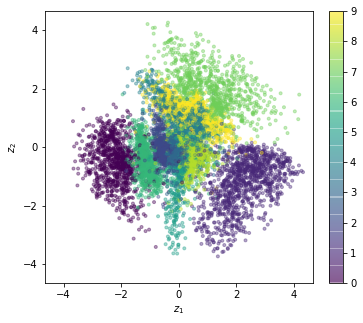

In [51]:
# display a 2D plot of the digit classes in the latent space
if data_type == "MNIST":
    z_test_mu, z_test_sigma = infer.predict(x_test, batch_size=batch_size)

    fig, ax = plt.subplots(figsize=(6, 5))

    cbar = ax.scatter(z_test_mu[:, 0], z_test_mu[:, 1], c=y_test,
                       alpha=.4, s=3**2, cmap='viridis')
    fig.colorbar(cbar, ax=ax)

    ax.set_xlim(2.*norm.ppf((quantile_min, quantile_max)))
    ax.set_ylim(2.*norm.ppf((quantile_min, quantile_max)))

    ax.set_xlabel('$z_1$')
    ax.set_ylabel('$z_2$')